# MDF Single model learning by substances and quantities

In [162]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
%matplotlib inline

In [2]:
from prepare_data import PROCESSED_BIG, PROCESSED_SUBSTANCES, PROCESSED_VOIE_ADMIN, TARGET_COLUMNS, TRAIN, TEST, SOURCE

-- get_unique_noconst --
- Number of found duplicated rows :  1389
- Remove constant columns :  (10846, 41) -> (10846, 41)
- Dropped const columns :  


In [3]:
PROCESSED_TRAIN = PROCESSED_BIG[PROCESSED_BIG[SOURCE] == TRAIN].drop(SOURCE, axis=1)
PROCESSED_TRAIN_SUBS = PROCESSED_SUBSTANCES[PROCESSED_SUBSTANCES[SOURCE] == TRAIN].drop(SOURCE, axis=1)
PROCESSED_TRAIN_VOIE_ADMIN = PROCESSED_VOIE_ADMIN[PROCESSED_VOIE_ADMIN[SOURCE] == TRAIN].drop(SOURCE, axis=1)

In [4]:
PROCESSED_TRAIN.columns.values

array([u'agrement col', u'date amm annee', u'date declar annee',
       u'etat commerc', u'forme pharma', u'libelle_ampoule',
       u'libelle_capsule', u'libelle_comprime', u'libelle_film',
       u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier',
       u'libelle_plaquette', u'libelle_poche', u'libelle_sachet',
       u'libelle_seringue', u'libelle_stylo', u'libelle_tube',
       u'nb_ampoule', u'nb_capsule', u'nb_comprime', u'nb_film',
       u'nb_flacon', u'nb_gelule', u'nb_ml', u'nb_pilulier',
       u'nb_plaquette', u'nb_poche', u'nb_sachet', u'nb_seringue',
       u'nb_stylo', u'nb_tube', u'prix', u'statut', u'statut admin',
       u'titulaires', u'tx rembours', u'type proc', 'logprix'], dtype=object)

In [5]:
PROCESSED_VOIE_ADMIN.columns.values

array([u'auriculaire', u'buccogingivale', u'cutan\xe9e', u'dentaire',
       u'endocanalaire', u'endosinusale', u'endotrach\xe9obronchique',
       u'gastrique', u'gastro-ent\xe9rale', u'gingivale', u'infiltration',
       u'inhal\xe9e', u'intra cholangio-pancr\xe9atique',
       u'intra-articulaire', u'intra-art\xe9rielle', u'intra-murale',
       u'intra-ut\xe9rine', u'intracaverneuse', u'intradermique',
       u'intradurale', u'intral\xe9sionnelle', u'intramusculaire',
       u'intrap\xe9riton\xe9ale', u'intras\xe9reuse', u'intrath\xe9cale',
       u'intraveineuse', u'intraventriculaire c\xe9r\xe9brale',
       u'intravitr\xe9enne', u'intrav\xe9sicale', u'nasale',
       u'ophtalmique', u'orale', u'p\xe9riarticulaire', u'p\xe9ridurale',
       u'p\xe9rineurale', u'p\xe9rioculaire', u'rectale',
       u'sous-cutan\xe9e', u'sublinguale', u'transdermique',
       u'ur\xe9trale', u'vaginale', u'voie buccale autre',
       u'voie extracorporelle autre', u'voie parent\xe9rale autre',
    

In [6]:
PROCESSED_SUBSTANCES.columns.values

array([ u' - A/CALIFORNIA/7/2009 A/CALIFORNIA/7/2009 ANALOGUE ANTIGENES GRIPPE H1N1PDM09 SOUCHE SOUCHE SURFACE VIRUS X-181',
       u' - A/CALIFORNIA/7/2009 A/CALIFORNIA/7/2009 ANALOGUE FRAGMENTE GRIPPE H1N1PDM09 INACTIVE NYMC SOUCHE SOUCHE VIRUS X-179A',
       u' - A/CALIFORNIA/7/2009 A/CHRISTCHURCH/16/2010 ANALOGUE FRAGMENTE GRIPPE H1N1 INACTIVE NIB-74XP PDM09 SOUCHE SOUCHE VIRUS',
       ..., u'ZUCLOPENTHIXOLCANOATE', '_ENCODED_', 'source'], dtype=object)

## Metric MAPE

In [7]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred, **kwards): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Learn by medecin types, substances and its quantities

In [8]:
types = [u'nb_capsule', u'nb_comprime',  u'nb_gelule', u'nb_ml']
packages = [u'nb_ampoule', u'nb_film', u'nb_flacon', u'nb_pilulier', u'nb_plaquette', u'nb_poche', u'nb_sachet', u'nb_seringue', u'nb_stylo', u'nb_tube']
types_and_packages = list(types)
types_and_packages.extend(packages)

In [9]:
df = PROCESSED_TRAIN
df_subs = PROCESSED_TRAIN_SUBS.drop(['_ENCODED_'], axis=1)

In [10]:
from common.preprocessing_helper import drop_const_cols

def create_df_subs_quants(df_subs, series_quants):
    cols = df_subs.columns
    df_subs_quants = pd.DataFrame(columns=cols)
    for c in cols:
        df_subs_quants[c] = df_subs[c] * series_quants
    return df_subs_quants

### Learn by type : 'capsule'

In [226]:
index = 0
print "Select type only : ", types[index]
mask = df[types[index]] > 0
print "Found lines (med has the type): ", len(df[mask])
indices = range(len(types))
indices.remove(index)
for i in indices:
    mask &= df[types[i]] < 1
    
print "Found lines (med has the type only) : ", len(df[mask])
df_prices = df[mask]['logprix']

Select type only :  nb_capsule
Found lines (med has the type):  46
Found lines (med has the type only) :  46


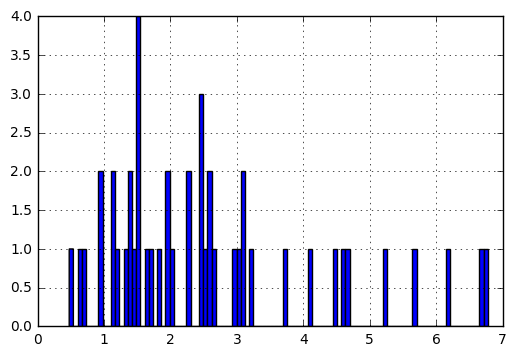

In [227]:
df_logprices.hist(bins=100)

In [179]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(46, 1766)


#### Add packages

In [180]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(46, 1776)


#### Add other features 

In [181]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(46, 1786)


#### Add voie admin

In [182]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(46, 1821)


#### Remove all zero columns

In [183]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape
# print "- Remove constant columns : ", df_subs_quants_others.shape, '->', res.shape
# print "- Dropped const columns : ", 
# if len(df_subs_quants_others.columns) > len(res.columns):
#     print df_subs_quants_others.columns.difference(res.columns).values
# print ""
# df_subs_quants_others = res
# del res

df_subs_quants ->  (46, 22)
df_subs_quants_packs ->  (46, 25)
df_subs_quants_others ->  (46, 34)
df_subs_quants_packs_va ->  (46, 27)


In [184]:
df_subs_quants_packs_va.head()

,ACETATEALPHA-TOCOPHEROL,ALFACALCIDOL,ALITRETINOINE,ALLOPURINOL,AMANTADINE CHLORHYDRATE,BASE FENTICONAZOLE,BASE VINORELBINE,BEXAROTENE,BROMHYDRATE DEXTROMETHORPHANE,CICLOSPORINE,DITARTRATE VINORELBINE,DUTASTERIDE,ECORCE EXTRAIT MOU PRUNIERAFRIQUE,ETOPOSIDE,EXTRAIT PRUNIERAFRIQUE,FENTICONAZOLE NITRATE,ISOTRETINOINE,MICONAZOLE NITRATE,NIFEDIPINE,PROGESTERONE,PROMESTRIENE,TIPRANAVIR,nb_film,nb_flacon,nb_plaquette,orale,vaginale
6,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,0,0,0,0,0,1,1
288,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
699,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,1,1


#### Split and learn

In [228]:
y = df_prices
X = StandardScaler().fit_transform(df_subs_quants)
XX = StandardScaler().fit_transform(df_subs_quants_packs_va)

X_train, X_test, XX_train, XX_test, y_train, y_test = train_test_split(X, XX, y, train_size=0.75)

In [229]:
rf = RandomForestRegressor(n_estimators = 35, n_jobs = -1, verbose = 0)

In [230]:
rf.fit(X_train, y_train)
score = rf.score(X_train, y_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(y_train, res0)
print mape_error(y_test, res1)

rf.fit(XX_train, y_train)
score = rf.score(XX_train, y_train)
print score
res01 = rf.predict(XX_train)
res11 = rf.predict(XX_test)
print mape_error(y_train, res01)
print mape_error(y_test, res11)


print res1[:10]
print res11[:10]
print y_test.values[:10]

0.819829250777
16.3748498057
33.7287309519
0.845878440907
19.2525748606
33.4426142057
[ 3.29994927  1.01085539  2.62384675  1.58736985  1.74086103  1.74086103
  1.58736985  1.29318921  2.74744736  1.97438366]
[ 3.27959211  1.10284631  2.60675291  1.63291412  1.77456835  1.77456835
  1.63291412  1.37025529  2.61483862  2.07141446]
[ 4.09999523  1.141033    2.50797192  2.45616418  1.37876609  1.37876609
  0.63657683  1.13140211  2.48490665  2.62900699]


In [231]:
X0 = df_subs_quants_packs_va
y = df_prices

X = StandardScaler().fit_transform(X0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [232]:
rf = RandomForestRegressor(n_estimators = 35, n_jobs = -1, verbose = 0)

In [233]:
rf.fit(X_train, y_train)
score = rf.score(X_train, y_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(y_train, res0)
print mape_error(y_test, res1)
print res1[:10]
print y_test.values[:10]

0.859556897946
15.5041447943
73.5645795048
[ 2.26963894  2.4697682   1.61988123  1.42617499  2.26963894  1.44128584
  3.75083625  2.26963894  2.26963894  2.26963894]
[ 0.63657683  1.65441128  1.49514877  1.85785927  6.77745295  1.19088756
  1.48839958  0.67294447  2.30058309  4.49880917]


In [234]:
svr = SVR(kernel='linear', C=3)
svr.fit(X_train, y_train)
score = svr.score(X_train, y_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(y_train, res0)
print mape_error(y_test, res1)

0.862491649107
11.1665434226
39.021910521


In [235]:
gbr = GradientBoostingRegressor(verbose = 0, max_features='auto')
gbr.fit(X_train, y_train)
score = gbr.score(X_train, y_train)
print score
res0 = gbr.predict(X_train)
res1 = gbr.predict(X_test)
print mape_error(y_train, res0)
print mape_error(y_test, res1)

0.96081958326
8.37145616334
81.8995525367


#### Cross validation scoring

In [236]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    y = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [237]:
run_cv(df_subs_quants, df_prices, rf)
run_cv(df_subs_quants_packs, df_prices, rf)
run_cv(df_subs_quants_others, df_prices, rf)
run_cv(df_subs_quants_packs_va, df_prices, rf)

[ 39.82465017  13.11174454  18.90098926  24.37635216  44.97610147
  76.74849456  15.38849408  57.03872576  23.13151125  55.56126664]
36.9058329892 20.2842148705
[ 36.11181726  16.41113533  35.60551417  32.27530896  42.4417552
  80.80293873  13.83362811  61.09583741  20.28651813  56.48611169]
39.5350565004 20.2715113688
[ 18.02193633  31.62821602  66.17845064  23.16007214  23.42318235
  62.42597303  13.51824175  65.17054121  42.58254462  63.94369086]
41.0052848953 20.5047194688
[ 40.11986204  16.79685674  33.16202432  23.37015754  43.19059805
  74.6289364   15.99508379  63.04579047  19.89860476  74.14761363]
40.4355527727 21.7867527494


In [114]:
run_cv(df_subs_quants, df_prices, svr)
run_cv(df_subs_quants_packs, df_prices, svr)
run_cv(df_subs_quants_others, df_prices, svr)
run_cv(df_subs_quants_packs_va, df_prices, svr)

[ 40.31172445  26.20863574  17.44950576  39.32853395  43.75747788
  65.00670025  23.5785269   44.45078557  20.70684904  60.22317809]
38.1021917651 15.4058053031
[ 41.26666762  23.76788611  30.8080135   39.33532982  44.77836295
  65.00623599  20.40450997  44.45204049  16.57446131  60.23004168]
38.6623549429 15.3038765088
[ 19.58778835  29.62359858  31.70621632  49.2868564   20.64653203
  60.92017443  25.75331389  48.23583442  48.44239325  58.65277129]
39.2855478961 14.752842293
[ 45.94031642  21.8653949   25.33490746  33.84845059  45.81990098
  56.07133287  19.56743934  37.4528097   16.44230933  87.73520639]
39.0078067998 20.3886358237


In [115]:
run_cv(df_subs_quants, df_prices, gbr)
run_cv(df_subs_quants_packs, df_prices, gbr)
run_cv(df_subs_quants_others, df_prices, gbr)
run_cv(df_subs_quants_packs_va, df_prices, gbr)

[ 35.28044582  20.36041236  37.03209974  45.40510218  43.87191871
  95.04584153  15.69540141  78.14119427  27.81635906  78.31620278]
47.696497786 25.6139093335
[ 35.49855605  19.28414731  66.56750642  45.41915145  44.89685035
  94.96380945  14.3228962   80.28056092  28.3243635   81.45403404]
51.1011875697 26.7092487022
[ 16.23262087  33.25311359  64.58197125  38.38987606  35.52447295
  77.50326534  19.13421982  73.35825393  41.30946841  58.72493934]
45.8012201566 20.5128014822
[  31.90374038   18.24627488   48.97910187   31.55694861   35.7815043
  106.06882197   15.53573496   85.49026693   23.10435506   86.75574656]
48.3422495547 30.8497396008


### Learn by type : 'gelule'

In [116]:
index = 2
print "Select type only : ", types[index]
mask = df[types[index]] > 0
print "Found lines (med has the type): ", len(df[mask])
indices = range(len(types))
indices.remove(index)
for i in indices:
    mask &= df[types[i]] < 1
    
print "Found lines (med has the type only) : ", len(df[mask])
df_logprices = df[mask]['logprix']

Select type only :  nb_gelule
Found lines (med has the type):  914
Found lines (med has the type only) :  914


In [117]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(914, 1766)


#### Add packages

In [118]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(914, 1776)


#### Add other features 

In [119]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(914, 1786)


#### Add voie admin

In [120]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(914, 1821)


#### Remove all zero columns

In [121]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape

df_subs_quants ->  (914, 210)
df_subs_quants_packs ->  (914, 212)
df_subs_quants_others ->  (914, 221)
df_subs_quants_packs_va ->  (914, 215)


#### Split and learn

In [122]:
X0 = df_subs_quants_packs_va
ylog = df_logprices

X = StandardScaler().fit_transform(X0)
X_train, X_test, ylog_train, ylog_test = train_test_split(X, ylog, train_size=0.80)

In [123]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1, verbose = 0)

In [124]:
rf.fit(X_train, ylog_train)
score = rf.score(X_train, ylog_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.922428741666
11.7324433667
18.5461738183


In [125]:
svr = SVR(kernel='linear', C=1)
svr.fit(X_train, ylog_train)
score = svr.score(X_train, ylog_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.853113564165
20.7037138728
30.0092200241


In [126]:
gbr = GradientBoostingRegressor(verbose = 0, max_features='auto')
gbr.fit(X_train, ylog_train)
score = gbr.score(X_train, ylog_train)
print score
res0 = gbr.predict(X_train)
res1 = gbr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.685590558069
52.8766298965
52.9485326249


#### Cross validation scoring

In [127]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    ylog = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, ylog, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [128]:
run_cv(df_subs_quants, ylog, rf)
run_cv(df_subs_quants_packs, ylog, rf)
run_cv(df_subs_quants_others, ylog, rf)
run_cv(df_subs_quants_packs_va, ylog, rf)

[ 15.44636899  18.63570784  19.35175257  19.52729308  20.54511488
  19.44044115  39.56302148  17.20205912  14.59063412  16.351957  ]
20.0654350242 6.75956879786
[ 21.4300088   18.74574086  19.29713301  19.08611346  19.67639429
  19.85322305  39.95960394  17.49422374  13.52401345  17.15329128]
20.6219745865 6.75212483817
[ 17.00210591  16.09570622  22.60127515  20.95559206  20.12379177
  20.8816152   43.56505833  20.66572466  17.10505515  17.62789622]
21.6623820666 7.58175996181
[ 21.73616167  18.24239292  19.04203987  18.55831709  19.87086981
  19.13508888  40.40624522  18.21816052  13.26793042  17.07900293]
20.5556209334 6.92979045402


In [129]:
run_cv(df_subs_quants, ylog, svr)
run_cv(df_subs_quants_packs, ylog, svr)
run_cv(df_subs_quants_others, ylog, svr)
run_cv(df_subs_quants_packs_va, ylog, svr)

[ 28.64346838  27.7085012   28.41081883  31.5556663   25.66205787
  29.05280042  44.01797872  24.95934422  31.81949553  27.36131098]
29.9191442445 5.1368421559
[ 28.85210342  27.178233    27.93869947  32.11744714  26.71187001
  27.96184892  43.17785544  25.56534056  31.15438433  27.34548902]
29.8003271308 4.84025674993
[ 25.09907603  28.41641543  26.57142711  30.68089314  25.88680316
  27.25083559  37.89695407  24.02825541  25.42270978  26.65932334]
27.791269307 3.80226547054
[ 28.85460276  27.23887357  27.90092124  32.12547614  26.78047683
  28.06189457  44.55234032  25.43965838  31.39143502  27.43230279]
29.9777981621 5.2256355818


In [130]:
run_cv(df_subs_quants, ylog, gbr)
run_cv(df_subs_quants_packs, ylog, gbr)
run_cv(df_subs_quants_others, ylog, gbr)
run_cv(df_subs_quants_packs_va, ylog, gbr)

[ 43.70920401  67.89937465  50.73806564  47.52554874  64.59929876
  53.73597136  92.09906051  48.41747377  72.54632581  52.16609344]
59.3436416693 14.1723464545
[ 44.5155889   63.95881162  48.94713807  46.08994632  62.23619347
  52.77364673  90.72240523  48.71886536  72.3552735   50.24484585]
58.0562715036 13.8183952121
[ 37.42296896  53.72090366  42.00857675  40.96162901  51.01971289
  44.74302117  78.55074065  41.82970633  59.58617133  41.76006787]
49.1603498617 11.7511573861
[ 44.5155889   63.9657285   48.83882515  46.08994632  62.23619347
  52.77364673  90.68467266  48.71886536  72.3552735   50.24460239]
58.0423342977 13.8169652996


### Learn by type : 'ml'

In [131]:
index = 3
print "Select type only : ", types[index]
mask = df[types[index]] > 0
print "Found lines (med has the type): ", len(df[mask])
indices = range(len(types))
indices.remove(index)
for i in indices:
    mask &= df[types[i]] < 1
    
print "Found lines (med has the type only) : ", len(df[mask])
df_logprices = df[mask]['logprix']

Select type only :  nb_ml
Found lines (med has the type):  1199
Found lines (med has the type only) :  1199


In [132]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(1199, 1766)


#### Add packages

In [133]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(1199, 1776)


#### Add other features 

In [134]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(1199, 1786)


#### Add voie admin

In [135]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(1199, 1821)


#### Remove all zero columns

In [136]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape

df_subs_quants ->  (1199, 673)
df_subs_quants_packs ->  (1199, 680)
df_subs_quants_others ->  (1199, 690)
df_subs_quants_packs_va ->  (1199, 718)


#### Split and learn

In [137]:
X0 = df_subs_quants_packs_va
ylog = df_logprices

X = StandardScaler().fit_transform(X0)
X_train, X_test, ylog_train, ylog_test = train_test_split(X, ylog, train_size=0.80)

In [138]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1, verbose = 0)

In [139]:
rf.fit(X_train, ylog_train)
score = rf.score(X_train, ylog_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.942072360224
17.3655238236
41.7114435398


In [140]:
svr = SVR(kernel='linear', C=3)
svr.fit(X_train, ylog_train)
score = svr.score(X_train, ylog_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.908202114974
24.2475791733
121.286789766


#### Cross validation scoring

In [141]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    ylog = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, ylog, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [142]:
run_cv(df_subs_quants, ylog, rf, cv=7)
run_cv(df_subs_quants_packs, ylog, rf, cv=7)
run_cv(df_subs_quants_others, ylog, rf, cv=7)
run_cv(df_subs_quants_packs_va, ylog, rf, cv=7)

[ 94.86952046  43.22315526  67.14238655  58.72756498  41.60611318
  31.45924302  26.75118415]
51.968452512 21.8985717226
[ 106.18536685   41.02230305   64.60589034   57.8050602    37.37746304
   31.74642638   25.56723015]
52.044248572 25.5563088495
[ 160.60426227   43.7634811    62.66017391   64.36081015   38.98050468
   31.61987356   32.69195534]
62.0972944304 42.0427076716
[ 73.84457094  40.19792843  68.06131819  56.43848595  37.96110813
  29.39366841  24.33014159]
47.175317378 17.748058697


In [144]:
# run_cv(df_subs_quants, ylog, svr, cv=7)
# run_cv(df_subs_quants_packs, ylog, svr, cv=7)
# run_cv(df_subs_quants_others, ylog, svr, cv=7)
# run_cv(df_subs_quants_packs_va, ylog, svr, cv=7)

### Learn by type : 'comprime'

In [145]:
index = 1
print "Select type only : ", types[index]
mask = df[types[index]] > 0
print "Found lines (med has the type): ", len(df[mask])
indices = range(len(types))
indices.remove(index)
for i in indices:
    mask &= df[types[i]] < 1
    
print "Found lines (med has the type only) : ", len(df[mask])
df_logprices = df[mask]['logprix']

Select type only :  nb_comprime
Found lines (med has the type):  4626
Found lines (med has the type only) :  4626


In [146]:
df_subs_quants = create_df_subs_quants(df_subs[mask], df[mask][types[index]])
print df_subs_quants.shape

(4626, 1766)


#### Add packages

In [147]:
df_subs_quants_packs = pd.concat([df_subs_quants, df[mask][packages]], axis=1)
print df_subs_quants_packs.shape

(4626, 1776)


#### Add other features 

In [148]:
cols_to_drop = list(types); cols_to_drop.extend(packages); cols_to_drop.extend(TARGET_COLUMNS)
cols_to_drop.extend([u'libelle_ampoule', u'libelle_capsule', u'libelle_comprime', u'libelle_film', u'libelle_flacon', u'libelle_gelule', u'libelle_pilulier', u'libelle_plaquette', u'libelle_poche', u'libelle_sachet', u'libelle_seringue', u'libelle_stylo', u'libelle_tube'])
other_features = df.drop(cols_to_drop, axis=1)
df_subs_quants_others = pd.concat([df_subs_quants_packs, other_features[mask]], axis=1)
print df_subs_quants_others.shape

(4626, 1786)


#### Add voie admin

In [149]:
df_subs_quants_packs_va = pd.concat([df_subs_quants_packs, PROCESSED_TRAIN_VOIE_ADMIN[mask]], axis=1)
print df_subs_quants_packs_va.shape

(4626, 1821)


#### Remove all zero columns

In [150]:
df_subs_quants = drop_const_cols(df_subs_quants)
df_subs_quants_packs = drop_const_cols(df_subs_quants_packs)
df_subs_quants_others = drop_const_cols(df_subs_quants_others)
df_subs_quants_packs_va = drop_const_cols(df_subs_quants_packs_va)

print "df_subs_quants -> ", df_subs_quants.shape
print "df_subs_quants_packs -> ", df_subs_quants_packs.shape
print "df_subs_quants_others -> ", df_subs_quants_others.shape
print "df_subs_quants_packs_va -> ", df_subs_quants_packs_va.shape

df_subs_quants ->  (4626, 761)
df_subs_quants_packs ->  (4626, 766)
df_subs_quants_others ->  (4626, 776)
df_subs_quants_packs_va ->  (4626, 772)


#### Split and learn

In [151]:
X0 = df_subs_quants_packs_va
ylog = df_logprices

X = StandardScaler().fit_transform(X0)
X_train, X_test, ylog_train, ylog_test = train_test_split(X, ylog, train_size=0.80)

In [152]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs = -1, verbose = 0)

In [153]:
rf.fit(X_train, ylog_train)
score = rf.score(X_train, ylog_train)
print score
res0 = rf.predict(X_train)
res1 = rf.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.932035926472
13.4392035208
24.6039827228


In [154]:
svr = SVR(kernel='linear', C=3)
svr.fit(X_train, ylog_train)
score = svr.score(X_train, ylog_train)
print score
res0 = svr.predict(X_train)
res1 = svr.predict(X_test)
print mape_error(ylog_train, res0)
print mape_error(ylog_test, res1)

0.834960840086
28.2416501109
36.8112215735


#### Cross validation scoring

In [155]:
def run_cv(data, targets, clf, cv=10):
    X0 = data
    ylog = targets
    X = StandardScaler().fit_transform(X0)
    scores = cross_val_score(clf, X, ylog, cv=cv, scoring=make_scorer(mape_error))
    print scores      
    print scores.mean(), scores.std()

In [156]:
run_cv(df_subs_quants, ylog, rf, cv=5)
run_cv(df_subs_quants_packs, ylog, rf, cv=5)
run_cv(df_subs_quants_others, ylog, rf, cv=5)
run_cv(df_subs_quants_packs_va, ylog, rf, cv=5)

[ 24.64669103  21.02139622  25.61395546  18.41282473  22.60143702]
22.4592608915 2.57675233526
[ 24.25376455  19.84213633  25.07687876  17.1858631   21.02716185]
21.4771609172 2.89684441581
[ 35.71147646  28.84464981  33.58820139  25.88180725  27.20050356]
30.245327692 3.77694983167
[ 24.95401988  19.66343652  23.81639664  17.02089966  21.25796491]
21.3425435211 2.85187202578


In [ ]:
# run_cv(df_subs_quants, ylog, svr, cv=5)
# run_cv(df_subs_quants_packs, ylog, svr, cv=5)
# run_cv(df_subs_quants_others, ylog, svr, cv=5)
# run_cv(df_subs_quants_packs_va, ylog, svr, cv=5)